# 3.0 Regression Analysis

- Import cleaned data tables exported from section 1.0 into the folder 'data'

**Objectives:**
- Test assumptions of linear regression for dependent and independent variables
- Run linear regression model (simple + multiple)

In [1]:
#Importing required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
# Read in data from Section 1.0
lsoa_strat_gent = pd.read_csv('data/lsoa_strat_gent.csv')

## 3.1 Check distribution of variables

### 3.1.1 Dependent variable: Professionalisation rate

In [3]:
# Dependent var: rate of professionalisation
lsoa_strat_gent.prop.describe()

count    4695.000000
mean        0.653219
std         0.205971
min         0.111111
25%         0.500000
50%         0.642857
75%         0.795364
max         1.000000
Name: prop, dtype: float64

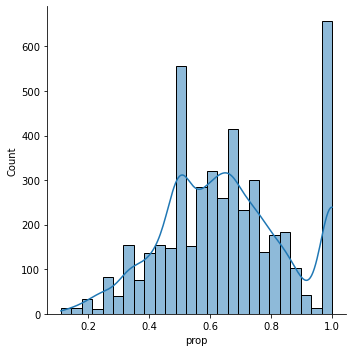

In [4]:
# lsoa_strat_gent.boxplot(column = ["prop"], grid = False)
# sns.boxplot(data = lsoa_strat_gent, x = "prop")

sns.displot(data = lsoa_strat_gent, x = "prop", kde = True)

How to deal with large spike of LSOAs with 100% professionalisation rate?
- Restrict dataset to only LSOAs with >5 airbnbs, OR
- Restrict to only inner-city LSOAs (calculated by borough), OR
- Try analysis at larger geographic unit (e.g. MSOA?)

### 3.1.2 Independent variables: Cultural density (points by area)

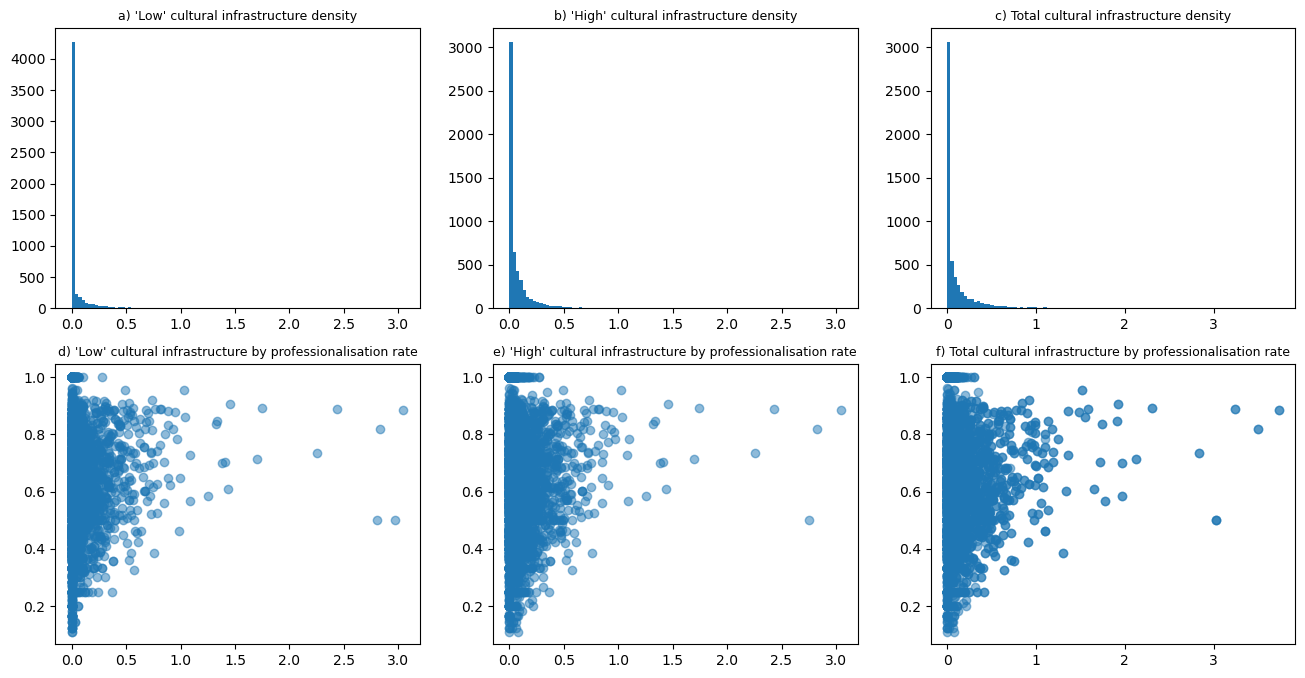

In [5]:
# Distribution plots for cultural infrastructure density measures
fig, axs = plt.subplots(2, 3, figsize=(16,8))

axs[0,0].hist(lsoa_strat_gent.clt_low_density,
        bins = 100)
axs[0,0].set_title("a) 'Low' cultural infrastructure density", fontsize=9)
axs[0,1].hist(lsoa_strat_gent.clt_high_density,
        bins = 100)
axs[0,1].set_title("b) 'High' cultural infrastructure density", fontsize=9)
axs[0,2].hist(lsoa_strat_gent.clt_total_density,
        bins = 100)
axs[0,2].set_title("c) Total cultural infrastructure density", fontsize=9)

axs[1,0].scatter(x=lsoa_strat_gent['clt_low_density'], 
            y=lsoa_strat_gent['prop'],
            alpha = 0.5)
axs[1,0].set_title("d) 'Low' cultural infrastructure by professionalisation rate", fontsize=9)
axs[1,1].scatter(x=lsoa_strat_gent['clt_high_density'], 
            y=lsoa_strat_gent['prop'],
            alpha = 0.5)
axs[1,1].set_title("e) 'High' cultural infrastructure by professionalisation rate", fontsize=9)
axs[1,2].scatter(x=lsoa_strat_gent['clt_total_density'], 
            y=lsoa_strat_gent['prop'],
            alpha = 0.5)
axs[1,2].set_title("f) Total cultural infrastructure by professionalisation rate", fontsize=9)

plt.show()

### 3.1.3 Transformations for linear regression

The histograms and scatterplots above show that cultural density variables are skewed to the left, with a high zero count. Therefore, need to transform to approximate a normal distribution to input into regression model. 

In [6]:
#Log transformation of cultural density vars
lsoa_strat_gent["clt_high_log"] = np.log(lsoa_strat_gent.clt_high_density + 1)
lsoa_strat_gent["clt_low_log"] = np.log(lsoa_strat_gent.clt_low_density + 1)
lsoa_strat_gent["clt_total_log"] = np.log(lsoa_strat_gent.clt_total_density + 1)

In [7]:
#Is this creating NA values?
nalist = pd.isna(lsoa_strat_gent.clt_total_log)

checkfornas = lsoa_strat_gent
checkfornas["nalist"] = nalist

checkfornas[checkfornas["nalist"] == True]

,Unnamed: 0.1,LSOA_CODE,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,...,clt_total_density,Unnamed: 0,LSOA_Code,Class_1_status,Class_2_status,Class_3_status,clt_high_log,clt_low_log,clt_total_log,nalist


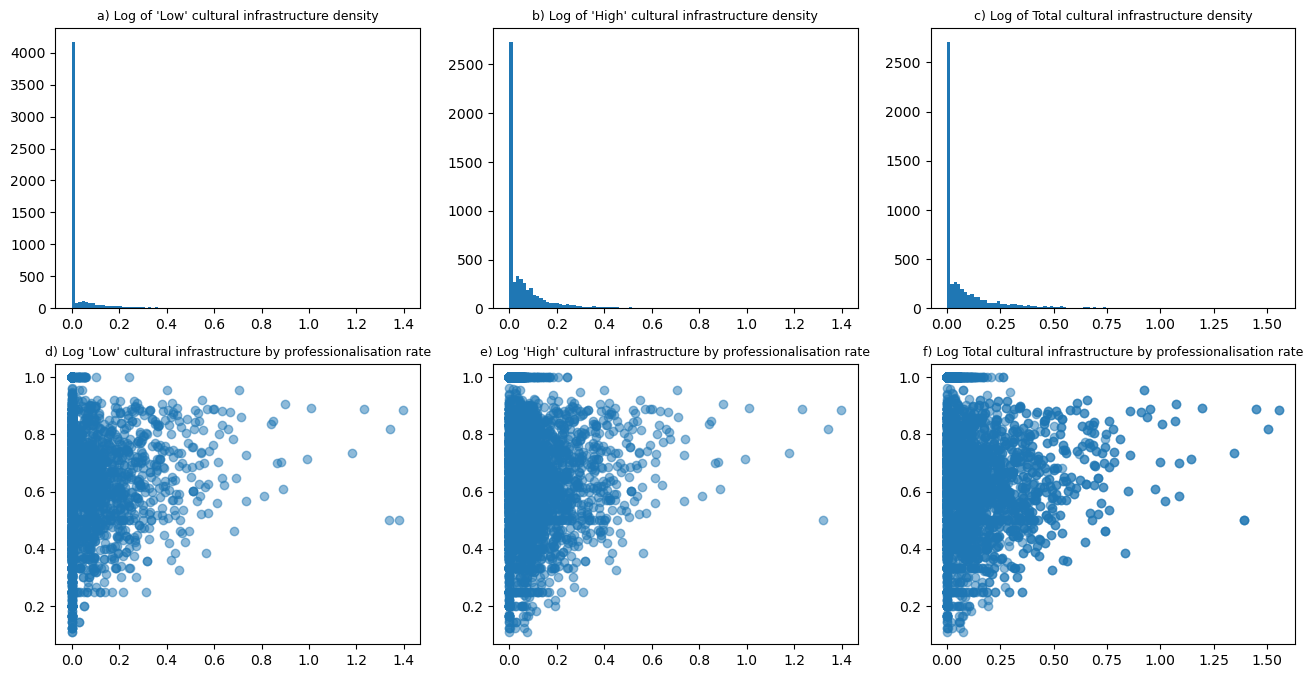

In [8]:
# Distribution plots for cultural infrastructure density measures
fig, axs = plt.subplots(2, 3, figsize=(16,8))

#Could probably do this in a loop somehow...
axs[0,0].hist(lsoa_strat_gent.clt_low_log,
        bins = 100)
axs[0,0].set_title("a) Log of 'Low' cultural infrastructure density", fontsize=9)
axs[0,1].hist(lsoa_strat_gent.clt_high_log,
        bins = 100)
axs[0,1].set_title("b) Log of 'High' cultural infrastructure density", fontsize=9)
axs[0,2].hist(lsoa_strat_gent.clt_total_log,
        bins = 100)
axs[0,2].set_title("c) Log of Total cultural infrastructure density", fontsize=9)

axs[1,0].scatter(x=lsoa_strat_gent['clt_low_log'], 
            y=lsoa_strat_gent['prop'],
            alpha = 0.5)
axs[1,0].set_title("d) Log 'Low' cultural infrastructure by professionalisation rate", fontsize=9)
axs[1,1].scatter(x=lsoa_strat_gent['clt_high_log'], 
            y=lsoa_strat_gent['prop'],
            alpha = 0.5)
axs[1,1].set_title("e) Log 'High' cultural infrastructure by professionalisation rate", fontsize=9)
axs[1,2].scatter(x=lsoa_strat_gent['clt_total_log'], 
            y=lsoa_strat_gent['prop'],
            alpha = 0.5)
axs[1,2].set_title("f) Log Total cultural infrastructure by professionalisation rate", fontsize=9)

plt.show()

- 'Total' cultural infrastructure closest to a usable distribution
- **Approach**: add pubs and 'night-time' economy spaces back into the cultural points dataset, and see how the distribution changes? Inclusion of pubs likely to reduce the skew towards 'zero' for many LSOAs, which will hopefully lead to closer to normal distribution (once log transformed)

## 3.2 Dummy variables for categorical inputs

In [9]:
# Turn gentrification category into dummy vars
# First, create subset df with just gent category column

df_gentcats_dummies = pd.get_dummies(lsoa_strat_gent[['Class_3_status']])
df_gentcats_dummies

,Class_3_status_DEC,Class_3_status_IUP,Class_3_status_MainGen,Class_3_status_MargGen,Class_3_status_NRW,Class_3_status_STB,Class_3_status_SupGen
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
5414,0,0,0,0,0,1,0
5415,0,0,0,0,0,0,0
5416,0,0,0,0,0,0,0
5417,0,0,0,0,0,1,0


In [10]:
# Add dummy vars onto main df
linreg_m1 = lsoa_strat_gent.join(df_gentcats_dummies)

# linreg_m1.dtypes

## 3.3 Multiple Linear Regression

Summary:

| Var Type  | Var Name  | Data Type | Included in models  | Data Source |
|---|---|---|---|---|
| Outcome (Dependent)  | Airbnb Professionalisation Rate  | Numeric (ratio) | M1, ...  | Inside Airbnb |
| Predictor (Independent)  | Gentrification category  | Categorical (binary dummies) | M1, ...  | Yee & Dennett |
| Predictor (Independent)  | Cultural point density (Total)  | Numeric (ratio) | M1  | Greater London Authority (GLA) |
| Predictor (Independent)  | Cultural point density ('Low') | Numeric (ratio) | *TBC* | Greater London Authority (GLA) |
| Predictor (Independent)  | Cultural point density ('High') | Numeric (ratio) | *TBC* | Greater London Authority (GLA) |

In [11]:
linreg_m1.columns

Index(['Unnamed: 0.1', 'LSOA_CODE', 'LSOA_NAME', 'MSOA_CODE', 'MSOA_NAME',
       'STWARDCODE', 'STWARDNAME', 'LA_CODE', 'LA_NAME', 'geometry',
       'casual_or_prof', 'professional_count', 'total_count', 'prop', 'area',
       'high_count', 'total_clt_count', 'low_count', 'clt_low_density',
       'clt_high_density', 'clt_total_density', 'Unnamed: 0', 'LSOA_Code',
       'Class_1_status', 'Class_2_status', 'Class_3_status', 'clt_high_log',
       'clt_low_log', 'clt_total_log', 'nalist', 'Class_3_status_DEC',
       'Class_3_status_IUP', 'Class_3_status_MainGen',
       'Class_3_status_MargGen', 'Class_3_status_NRW', 'Class_3_status_STB',
       'Class_3_status_SupGen'],
      dtype='object')

In [12]:
#Selecting only relevant columns
linreg_m1_c = linreg_m1[["LSOA_CODE", "geometry", "prop"
                         # , "clt_high_density"
                         , "clt_total_log"
                         , 'Class_3_status_DEC', 'Class_3_status_IUP', 'Class_3_status_MainGen'
                         ,'Class_3_status_MargGen', 'Class_3_status_NRW', 'Class_3_status_STB'
                         ,'Class_3_status_SupGen']]


| Term | Code|
| --- | --- |
| Marginal Gentrification | MargGen |
| Mainstream Gentrification | MainGen |
| Super Gentrification | SupGen |
| Stable | STB |
| Declining | DEC |
| Incumbernt Upgrading | IUP |
| Re-urbanisaiton | NRW |


In [13]:
#Removing 1 of the dummy columns, as can't have all 7.
linreg_m1_c = linreg_m1_c.drop(axis=1, labels="Class_3_status_SupGen")

linreg_m1_c.shape

(5419, 10)

In [14]:
#Dropped any NA values in the prop column 
linreg_m1_c = linreg_m1_c.dropna(subset="prop")

#Drop any NA values in the independent vars
# linreg_m1_c = linreg_m1_c.dropna(subset="clt_total_log")

linreg_m1_c.shape

(4695, 10)

In [15]:
y = np.array(linreg_m1_c['prop']).reshape(-1, 1)
X = np.array(linreg_m1_c[[ 'clt_total_log',  #'clt_high_density',
       'Class_3_status_DEC', 'Class_3_status_IUP', 'Class_3_status_MainGen',
       'Class_3_status_MargGen', 'Class_3_status_NRW', 'Class_3_status_STB']])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
m1 = linear_model.LinearRegression()

In [20]:
m1.fit(X_train,y_train)

LinearRegression()

In [21]:
m1.score(X_test,y_test)

-0.0013801077592605626

In [22]:
y_pred = m1.predict(X_test)

In [23]:
y_pred.mean()

0.6548873824267362

In [24]:
y_test.mean()

0.6505327376548533

In [25]:
y_pred = pd.DataFrame(y_pred)
y_pred["type"] = "Predicted"

y_test = pd.DataFrame(y_test)
y_test["type"] = "Observed"

In [26]:
y_main = pd.concat([y_test, y_pred], axis=0)

In [27]:
y_main = y_main.reset_index(drop=True)

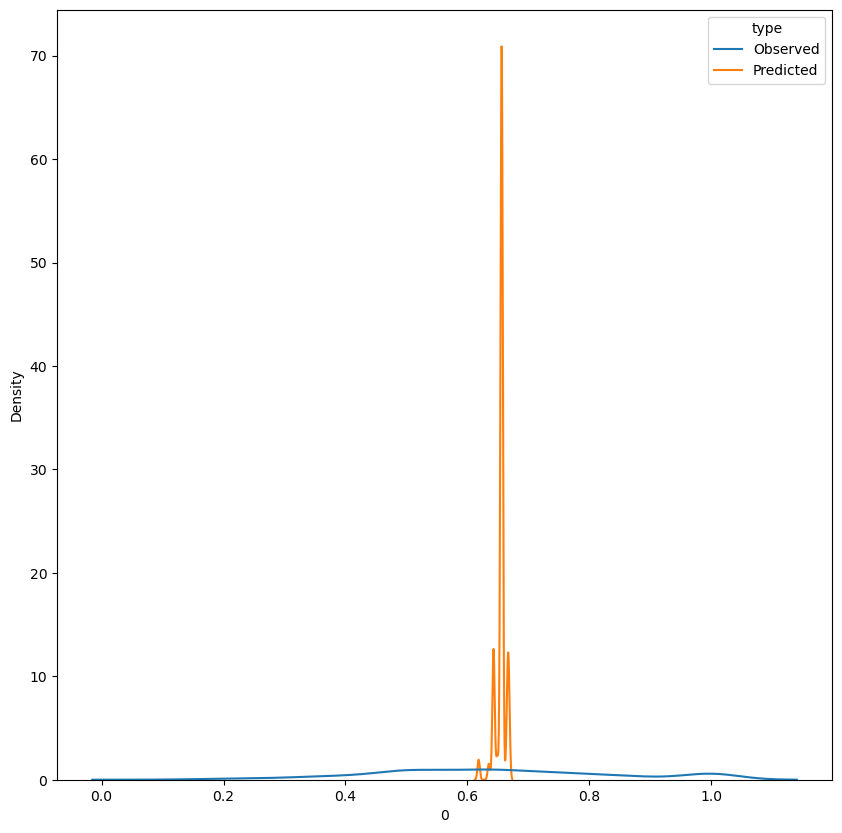

In [28]:
fig, ax = plt.subplots(1, figsize=(10,10))

sns.kdeplot(data = y_main, x=0, hue="type", common_norm = True, ax=ax)

plt.show()


## 3.4 Logistic regression
Beginnings of logistic regression

In [ ]:
lsoa_dummies = lsoa_clt_gent.merge(pd.get_dummies(lsoa_clt_gent[['predictions']]), left_index = True, right_index = True, how = "left")
lsoa_dummies

In [ ]:
from sklearn import linear_model
lsoa_dummies = lsoa_dummies.dropna()
X = np.array(lsoa_dummies['prop']).reshape(-1, 1)
y = np.array(lsoa_dummies['predictions_GEN'])
logr = linear_model.LogisticRegression()
logr.fit(X,y)


In [ ]:
sns.kdeplot(data = lsoa_dummies, hue = 'predictions_GEN', x = 'prop')

In [ ]:
log_odds = logr.coef_
odds = np.exp(log_odds)

print(odds)